In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
register_matplotlib_converters()
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sms
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARMA

In [70]:
df = pd.read_csv('FX_EURUSD, 1D.csv')
cols = ['time','open']
df = df[cols]

In [71]:
df.head()

,time,open
0,2012-10-11T04:00:00+07:00,1.28721
1,2012-10-12T04:00:00+07:00,1.29268
2,2012-10-15T04:00:00+07:00,1.29538
3,2012-10-16T04:00:00+07:00,1.29490
4,2012-10-17T04:00:00+07:00,1.30529


In [72]:
df = df.astype({'time':'datetime64'})
df['date'] = pd.to_datetime(df['time'],unit='s').dt.date
df['date'] = pd.to_datetime(df['date'])
df.drop('time',axis=1,inplace=True)

In [73]:
df.set_index('date',inplace=True)

In [74]:
# df.Timestamp = pd.to_datetime(df.date, format='%Y-%m-%d')
# df.index = df.Timestamp
# # df = df.resample('D').sum()

In [75]:
df = df.asfreq(pd.infer_freq(df.index))

In [76]:
df.head()

,open
date,
2012-10-10,1.28721
2012-10-11,1.29268
2012-10-12,NaN
2012-10-13,NaN
2012-10-14,1.29538


In [77]:
test_size = 0.3
train_samples = int((1-test_size)*len(df))
train_samples

2460

In [78]:
train_data = df[:train_samples]
test_data = df[train_samples:]

In [79]:
pred_start_date = test_data.index[0]
pred_end_date=test_data.index[-1]
pred_start_date, pred_end_date

(Timestamp('2019-07-06 00:00:00', freq='D'),
 Timestamp('2022-05-25 00:00:00', freq='D'))

In [80]:
test_data

,open
date,
2019-07-06,NaN
2019-07-07,1.12261
2019-07-08,1.12140
2019-07-09,1.12077
2019-07-10,1.12507
...,...
2022-05-21,NaN
2022-05-22,1.05620
2022-05-23,1.06885


Text(0.5, 1.0, 'Trading View Open Price')

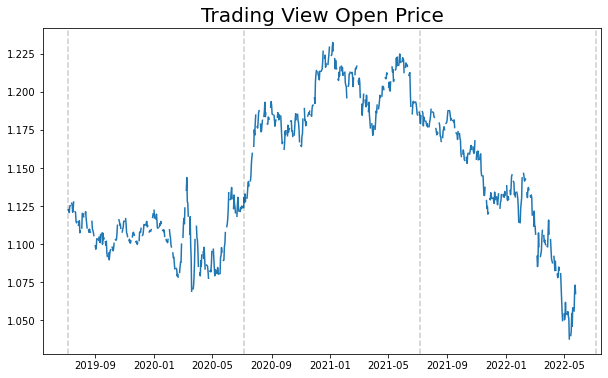

In [83]:
plt.figure(figsize=(10,6))
plt.plot(test_data)
for year in range(test_data.index[0].year,test_data.index[-1].year+1):
    plt.axvline(datetime(year,7,6),color='k',linestyle='--',alpha=0.2)
plt.title('Trading View Open Price',fontsize=20)

Buy if stock increase for b consecutive days
Sell if stock decrease for s consecutive days

In [84]:
def get_buying_selling_days(price_data, b, s):
    #percent change day after day
    pct_change = price_data.pct_change()[1:]
    #check buying condition
    def buying_condition(sub_series):
        return (sub_series > 0).all()
    #check selling condition
    def selling_condition(sub_series):
        return (sub_series < 0).all()
    # get all buying days
    buying_days = pct_change.rolling(b).apply(buying_condition)
    # get all potential selling days
    potential_selling_days = pct_change.rolling(s).apply(selling_condition)
    
    return {'buying_days': buying_days, 'potential_selling_days': potential_selling_days}

In [85]:
info_dict = get_buying_selling_days(test_data, 3, 3)

In [87]:
buying_days = info_dict['buying_days']
potential_selling_days = info_dict['potential_selling_days']

In [90]:
df_stocks = pd.DataFrame(index = buying_days.index)

In [91]:
df_stocks['buying_day'] = (buying_days == 1)
df_stocks['potential_selling_day'] = (potential_selling_days == 1)
df_stocks['price'] = test_data

In [95]:
df_stocks = df_stocks[(df_stocks.buying_day | df_stocks.potential_selling_day)]

In [96]:
df_stocks

,buying_day,potential_selling_day,price
date,,,
2019-07-23,False,True,1.11516
2019-07-24,False,True,1.11400
2019-08-15,False,True,1.11066
2019-08-28,False,True,1.10772
2019-08-29,False,True,1.10566
...,...,...,...
2022-04-26,False,True,1.06375
2022-04-27,False,True,1.05552
2022-04-28,False,True,1.04985


In [97]:
def check_cumulative_percent_change(price_data, buy_date, potential_sell_date):
    """
    This helper function will check if the cumulative percent change
    between a buying and potential selling day yields overall growth
    """
    
    #get the percent change day after day
    pct_change = price_data.pct_change()[1:]
    sub_series = 1 + pct_change[buy_date + timedelta(hours=1):potential_sell_date]
    return sub_series.product() > 1

In [99]:
price_data = df_stocks.price
holding = False
starting_funds = 10000
current_funds = starting_funds
current_shares = 0
last_buy_date = None
events_list = []

for date, data in df_stocks.iterrows():
    if not holding and data.buying_day:
        num_shares_to_buy = int(current_funds / data.price)
        current_shares += num_shares_to_buy
        current_funds -= num_shares_to_buy * data.price
        last_buy_date = date
        events_list.append(('b', date))
        holding = True
    elif holding and data.potential_selling_day:
        if check_cumulative_percent_change(price_data, last_buy_date, date):
            current_funds += current_shares * data.price
            current_shares = 0
            holding = False
            events_list.append(('s', date))
final_stock_price = price_data[-1]
final_value = current_funds + final_stock_price * current_shares

In [100]:
round((final_value - starting_funds) / starting_funds,2)

-0.02

In [103]:
test_data

,open
date,
2019-07-06,NaN
2019-07-07,1.12261
2019-07-08,1.12140
2019-07-09,1.12077
2019-07-10,1.12507
...,...
2022-05-21,NaN
2022-05-22,1.05620
2022-05-23,1.06885


(0.0, 1.0)

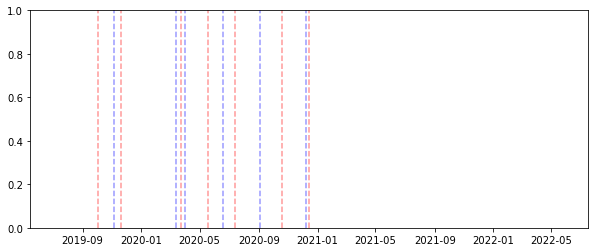

In [102]:
plt.figure(figsize=(10,4))
plt.plot(test_data)
y_lims = (int(test_data.min()*.95), int(test_data.max()*1.05))
shaded_y_lims = int(test_data.min()*.5), int(test_data.max()*1.5)
for idx, event in enumerate(events_list):
    color = 'red' if event[0] == 'b' else 'blue'
    plt.axvline(event[1], color=color, linestyle='--', alpha=0.4)
    if event[0] == 's':
        plt.fill_betweenx(range(*shaded_y_lims), 
                          event[1], events_list[idx-1][1], color='k', alpha=0.1)

plt.ylim(*y_lims)